In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline

import numpy as np
import matplotlib.pyplot as plt

import scipy

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd

from cleaner import clean

import warnings
import sys

from typing import List, Union, Optional
from typeguard import check_type, typechecked

warnings.filterwarnings("ignore")

In [9]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token, pos = 'n') for token in tokens if token.lower() not in stop_words]
    return ' '.join(lemmatized)

def stem_text(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(stemmed)

def category_to_binary(category):
    if category == 'sports':
        return 1
    elif category == "climate":
        return 0
    else:
        raise ValueError(f"Invalid Category {category}")

In [12]:
class Problem:
    def __init__(self, path_to_csv, path_to_glove_txt, random_state = 42):
        self.random_state = random_state
        self._get_dataframes(path_to_csv)
        self.path_to_glove_txt = path_to_glove_txt

    def _get_dataframes(self, path):
        df = pd.read_csv(path)
        df["clean_text"] = df["full_text"].apply(lambda x: clean(x))
        df['lemmatized_text'] = df['clean_text'].apply(lemmatize_text)
        df['stemmed_text'] = df['clean_text'].apply(stem_text)
        df['binary_category'] = df['root_label'].apply(category_to_binary)
        
        self.train_df_clean, self.test_df_clean = train_test_split(df[["clean_text", "binary_category"]], 
                                                                   test_size = 0.2, 
                                                                   random_state = self.random_state)
        self.train_df_lemmatized, self.test_df_lemmatized = train_test_split(df[["lemmatized_text", "binary_category"]], 
                                                                             test_size = 0.2,
                                                                             random_state = self.random_state)
        
        self.train_df_stemmed, self.test_df_stemmed = train_test_split(df[["stemmed_text", "binary_category"]], 
                                                                       test_size = 0.2,
                                                                       random_state = self.random_state)

        self.df = df

    def _do_LSI(self, n_components: int, tfidf_features: Optional[np.ndarray] = None, fit_on: Optional[str] = "lemmatized_text"):
        if tfidf_features is None:
            (train_X_tfidf, _), _ = self._do_tfidf(fit_on = fit_on, min_df = 3)
        else:
            train_X_tfidf = tfidf_features
            print(train_X_tfidf.shape)
        
        lsi = TruncatedSVD(n_components = n_components, random_state = self.random_state)
        U_sigma = lsi.fit_transform(train_X_tfidf)
        V_transpose = lsi.components_
        reconstruction = np.dot(U_sigma, V_transpose)

        explained_variance_ratio = lsi.explained_variance_ratio_
        total_explained_variance = np.sum(explained_variance_ratio)

        lsi_error = np.linalg.norm(reconstruction - train_X_tfidf, 'fro')

        return lsi, U_sigma, total_explained_variance, lsi_error

    def _fit_SVM(self, kernel: Optional[str] = 'linear', 
                       C: Optional[float] = 1.0, 
                       probability: Optional[bool] = True,
                       tfidf_features: Optional[np.ndarray] = None,
                       fit_on: Optional[str] = "lemmatized_text",
                       lsi_num_components: Optional[int] = 128,
                       ):
        
        if tfidf_features is None:
            (train_X_tfidf, _), _ = self._do_tfidf(fit_on = fit_on, min_df = 3)
        else:
            train_X_tfidf = tfidf_features
            print(train_X_tfidf.shape)
        
        if fit_on == "clean_text":
            df_train, df_test = self.train_df_clean, self.test_df_clean
        elif fit_on == "lemmatized_text":
            df_train, df_test = self.train_df_lemmatized, self.test_df_lemmatized
        else:
            df_train, df_test = self.train_df_stemmed, self.test_df_stemmed
        
        lsi_object, X_train_lsi, _, _ = self._do_LSI(n_components = lsi_num_components, 
                                                     tfidf_features = train_X_tfidf, 
                                                     fit_on = fit_on)

        svm = SVC(kernel = kernel, C = C, probability = probability, random_state = self.random_state)
        svm.fit(X_train_lsi, df_train["binary_category"])

        return lsi_object, svm
    
    def _predict_SVM(self, svm, lsi_object, 
                           X_test: Union[str, np.ndarray, scipy.sparse._csr.csr_matrix], 
                           y_test: Union[str, np.ndarray, pd.core.series.Series], 
                           roc: bool = False):
        
        if isinstance(X_test, str):
            assert X_test in ["clean_text", "lemmatized_text", "stemmed_text"]
            (_, X_test), _ = self._do_tfidf(fit_on = X_test, min_df = 3)
        
        if isinstance(y_test, str):
            assert y_test in ["clean_text", "lemmatized_text"]
            if y_test == "clean_text":
                y_test = self.test_df_clean["binary_category"]
            else:
                y_test = self.test_df_lemmatized["binary_category"]
        
        X_test = lsi_object.transform(X_test)
        y_pred = svm.predict(X_test)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        if roc:
            assert svm.probability, "set probability attribute to SVM to `True` to plot ROC curve"
            y_scores = svm.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)
        else:
            fpr, tpr, roc_auc = None, None, None

        return report, conf_matrix, [tpr, fpr, roc_auc]

    def _load_glove_embeddings(self):
        with open(self.path_to_glove_txt, encoding = "utf8") as f:
            word_embeddings = dict()
            for line in f:
                values = line.split(' ')
                word_embeddings[values[0]] = np.asarray(values[1:], dtype = np.float32)
        return word_embeddings
    
    def _get_text_embeddings(self, text, word_embeddings):
        '''
        Feature Engineering to get text embeddings from GLoVE embeddings
        '''
        if isinstance(text, str):
            words = text.split()
        else:
            words = text
        embeddings = []
        for word in words:
            if word in word_embeddings.keys():
                embeddings.append(word_embeddings[word])
        
        embeddings = np.asarray(embeddings, dtype = np.float32)
        if embeddings.shape[0] == 0:
            embeddings = np.random.random([len(words), 300])
        embeddings = embeddings.reshape([embeddings.shape[0], 10, 30])
        embeddings = np.mean(embeddings, axis = -1)
        embeddings = np.max(embeddings, axis = -1)

        # keep the top K = 300 embeddings while maintaining their relative order

        abs_embeddings = np.abs(embeddings)
        sorted_indices = np.argsort(abs_embeddings)
        top_indices = sorted_indices[-300:]
        top_indices = np.sort(top_indices)
        embeddings = embeddings[top_indices]
        embeddings = embeddings[..., np.newaxis]
        print(f"feature shape: {embeddings.shape}")
        return embeddings.T
    
    def _get_max_len(self, df):
        max_len = 0
        for arr  in df:
            if arr.shape[1] > max_len:
                max_len = arr.shape[1]
        
        return max_len
    
    def _pad_to_MAX_LEN(self, arr, max_len):
        padding = [
                    [0, 0],
                    [0, max(0, max_len - arr.shape[1])]
                  ]
        
        arr = np.pad(arr, pad_width = padding, mode = "symmetric")
        norm = np.linalg.norm(arr, axis = 1, keepdims = True)
                
        return arr/norm

    def Q11(self):
        fit_on = "keywords"

        word_embeddings = self._load_glove_embeddings()

        if fit_on == "clean_text":
            df_train, df_test = train_test_split(self.df[["clean_text", "binary_category"]], 
                                                         test_size = 0.2,
                                                         random_state = self.random_state)
            lsi_num_components = 300
        elif fit_on == "lemmatized_text":
            df_train, df_test = train_test_split(self.df[["lemmatized_text", "binary_category"]], 
                                                         test_size = 0.2,
                                                         random_state = self.random_state)
            lsi_num_components = 300
        elif fit_on == "stemmed_text":
            df_train, df_test = train_test_split(self.df[["stemmed_text", "binary_category"]], 
                                                         test_size = 0.2,
                                                         random_state = self.random_state)
            lsi_num_components = 300
        elif fit_on == "keywords":
            df_train, df_test = train_test_split(self.df[["keywords", "binary_category"]], 
                                                         test_size = 0.2,
                                                         random_state = self.random_state)
            lsi_num_components = 20
        else:
            raise ValueError("Invalid `fit_on`")

        df_train["embeddings"] = df_train[fit_on].apply(self._get_text_embeddings, args = [word_embeddings])
        df_test["embeddings"] = df_test[fit_on].apply(self._get_text_embeddings, args = [word_embeddings])

        max_len = self._get_max_len(df_train["embeddings"])
        df_train["embeddings"] = df_train["embeddings"].apply(lambda x: self._pad_to_MAX_LEN(x, max_len))

        max_len = self._get_max_len(df_test["embeddings"])
        df_test["embeddings"] = df_test["embeddings"].apply(lambda x: self._pad_to_MAX_LEN(x, max_len))

        embeddings = []
        for emb in df_train["embeddings"]:
            embeddings.append(emb)

        embeddings = np.squeeze(np.asarray(embeddings))

        lsi, svm = self._fit_SVM(probability = True, 
                                 tfidf_features = embeddings, 
                                 fit_on = "lemmatized_text", 
                                 lsi_num_components = lsi_num_components)
        
        embeddings = []
        for emb in df_test["embeddings"]:
            embeddings.append(emb)

        embeddings = np.squeeze(np.asarray(embeddings))
        
        report, conf_matrix, [tpr, fpr, roc_auc] = self._predict_SVM(svm = svm, lsi_object = lsi,
                                                                     X_test = embeddings, y_test = "lemmatized_text", roc = True)

        print('-'*70)
        print("SVM on Feature Engineered Data")
        print('-'*70)
        print(report)
        print('-'*27, "Confusion Matrix", '-'*25)
        print(conf_matrix)
        print('-'*70)

        fig, ax = plt.subplots(1, 1)
        ax.plot(fpr, tpr, label = 'ROC curve')
        ax.plot([0, 1], [0, 1], linestyle = '--')
        ax.set_xlim([-0.01, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC curve (Feature Enigneered Data)')
        ax.legend()
        plt.show()

feature shape: (12, 1)
feature shape: (17, 1)
feature shape: (12, 1)
feature shape: (15, 1)
feature shape: (15, 1)
feature shape: (13, 1)
feature shape: (13, 1)
feature shape: (10, 1)
feature shape: (15, 1)
feature shape: (14, 1)
feature shape: (17, 1)
feature shape: (13, 1)
feature shape: (13, 1)
feature shape: (13, 1)
feature shape: (16, 1)
feature shape: (14, 1)
feature shape: (13, 1)
feature shape: (17, 1)
feature shape: (15, 1)
feature shape: (15, 1)
feature shape: (15, 1)
feature shape: (12, 1)
feature shape: (17, 1)
feature shape: (14, 1)
feature shape: (17, 1)
feature shape: (17, 1)
feature shape: (14, 1)
feature shape: (12, 1)
feature shape: (13, 1)
feature shape: (16, 1)
feature shape: (13, 1)
feature shape: (15, 1)
feature shape: (12, 1)
feature shape: (16, 1)
feature shape: (17, 1)
feature shape: (16, 1)
feature shape: (12, 1)
feature shape: (17, 1)
feature shape: (14, 1)
feature shape: (14, 1)
feature shape: (17, 1)
feature shape: (16, 1)
feature shape: (12, 1)
feature sha

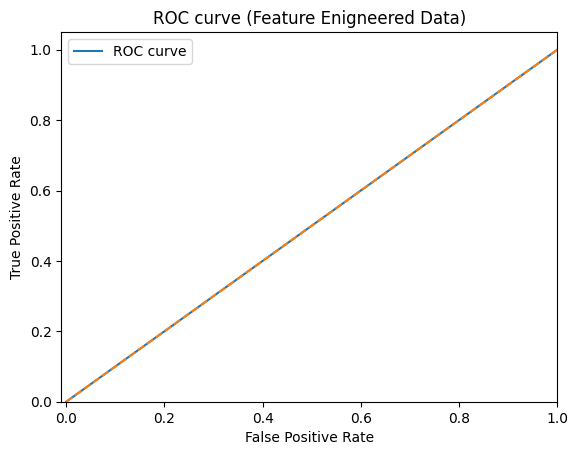

In [13]:
prob = Problem(path_to_csv = "./Dataset1.csv", path_to_glove_txt = "./glove.6B/glove.txt")
prob.Q11()